# Introduction and Data

This Notebook investigates whether word statistics about an excerpt of text from a novel can be used to determine the author. Text data was gathered from Project Gutenberg for ten English-language authors. The text is from three to seven books per author and split into non-overlapping passages based on a consistent number of tokens. No text is taken from poems or short stories. Statistics such as 'number of semicolons', 'number of sentences', 'number of adverbs', etc. were recorded per passage, then only those statistics were used to create a .csv file.

Although care was taken for the features to be accurate, it's possible that mistakes were made in creating the data set. The most obvious errors arising from the fact that English can be rather ambiguous, so the recorded part of speech for a word may not be how it was used in the text. The idea is that these errors will be infrequent enough to not make a real difference. Another possible source for error is different notations among transcribers. Project Gutenberg is fairly standardized, but there can be differences. One corrected difference is the type of quotation mark used. Another that would have been helpful is the use of italics, but this measure was more difficult to capture. It is possible the use of em dashes is another source of error, but they have been included since most books include them, and the ones that don't are not focused on a single author.

It's worth noting that for most authors, books spanning their careers have been selected for the training data. The reasoning is that it's more likely that books written closer together will be more similar than books written at the beginning and end of an authors career. This assumption is not examined here, but I am interested in investigating it later. For Charles Dickens, I have intentionally clumped them in a single time period to demonstrate the difficulty in identifying 'Oliver Twist'. However, it is unclear if this is a quirk of 'Oliver Twist' or an example of a more general phenomenon. 

To see more on the data collection process or the code for feature creation, you can look at other files.

In [18]:
#General
from collections import Counter

#Data Handling
import numpy as np
import pandas as pd

#Graphing
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

#Scaling
from sklearn.preprocessing import MinMaxScaler

#Model Selection and Metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

#Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

In [19]:
#######################################
### Data Loading and Basic Cleaning ###
#######################################

#Load DataFrame of 1200 token passages
df_train = pd.read_csv('Training_Data/1200_Train_Set.csv')
df_test = pd.read_csv('Test_Data/1200_Test_Set.csv')

#Get rid of Louisa May Alcott's middle name
df_train.Author.replace({'Louisa May Alcott': 'Louisa Alcott'}, inplace = True)
df_test.Author.replace({'Louisa May Alcott': 'Louisa Alcott'}, inplace = True)

#Only use last names (since we only have one Bronte)
df_train['Author'] = df_train.Author.apply(lambda x: x.split(' ')[1])
df_test['Author'] = df_test.Author.apply(lambda x: x.split(' ')[1])

In [20]:
######################
### Graphing Tools ###
######################

#Function for creating ten histograms, one for each author, on a specific feature
def author_hist(df, feature, bins):
    
    #Loop to create the data for the ten histograms
    a_list = []
    for author in df.Author.unique():
        a_list.append(df[feature][df.Author == author])
        
    #Create the figure and axis objects
    fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) =  \
    plt.subplots(2,5, figsize = (25,8), sharex = True)
    
    #Make it easier to access axes
    axis_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
    
    #Loop through axes and plot each histogram
    for i in range(len(a_list)):
        
        #Record author name
        author = df.Author.unique()[i]
        
        #Create the basic plot
        axis_list[i].hist(a_list[i], bins = bins)
    
        #Label the plot
        axis_list[i].set_title('Histogram of ' + feature + ' for ' + author)
        axis_list[i].set_xlabel('Number of ' + feature + ' in Passage')
        axis_list[i].set_ylabel(feature + ' in Passage')
    
    
#Function for creating a histogram of a feature
def book_hist(df, feature, bins):
    
    #Store info for plotting
    hist_num = df[feature]
    
    #Create a figure and axis object
    fig, ax = plt.subplots(figsize = (8,6))
    
    #Create the basic plot
    ax.hist(hist_num, bins = bins)
    
    #Label the plot
    ax.set_title('Histogram of ' + feature)
    ax.set_xlabel('Number of ' + feature + ' in Passage')
    ax.set_ylabel(feature + ' in Passage')
    
#Function for creating a Box-and-Whisker plot for all authors for a specified feature or for a specific author
#and their books
def literary_box(df, feature, author = None):
    
    #Compares all authors, regardless of book
    if author == None:
        #Create a list of author/feature combos to plot
        a_list = []
        for author in df.Author.unique():
            a_list.append(df[feature][df.Author == author])
      
        #Create a figure and axis object
        fig, ax = plt.subplots(figsize = (10,4))
    
        #Create the basic plot
        ax.boxplot(a_list, labels = df.Author.unique())
    
        #Label the plot
        ax.set_title(feature + ' Among Authors')
        ax.set_xlabel('Authors')
        ax.set_ylabel(feature)
    
        #Rotate the x labels
        plt.xticks(rotation = 45)
        
    #Compares books by a single author
    else:
        
        #Create a list of title/feature combos to plot
        df_temp = df[df.Author == author].copy()
        t_list = []
        for title in df_temp.Title.unique():
            t_list.append(df[feature][df.Title == title])
      
        #Create a figure and axis object
        fig, ax = plt.subplots(figsize = (10,4))
    
        #Create the basic plot
        ax.boxplot(t_list, labels = df_temp.Title.unique())
    
        #Label the plot
        ax.set_title(feature + ' Among Books By ' + author)
        ax.set_xlabel('Titles')
        ax.set_ylabel(feature + ' in Passage')
    
        #Rotate the x labels
        plt.xticks(rotation = 45)
        
#Calculates mean, median, SD, min, max, and percent of 0s for each author on a given feature
def stat_table(df, feature):
    
    #Create an empty DataFrame
    df_new = pd.DataFrame([], columns = ['Mean', 'SD', 'Median', 'Min', 'Max', '0_Per'], index = list(df.Author.unique()))
    
    #Cycle through each author and calculate statistics
    for author, data in df.groupby('Author'):
        data = data[feature]
        zero_data = len(data[data == 0]) / len(data) * 100
        df_new.loc[author] = [data.mean(), data.std(), data.median(), data.min(), data.max(), zero_data]
        
    return df_new
        

#Create a pie chart displaying percent of data by author
def author_pie(df1, df2):
    
    #Create basic plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,12))
    
    #Calculate the percentages for each author for df1
    x1 = Counter(df1.Author)
    size = df1.shape[0]
    for key in x1:
        x1[key] = x1[key] / size * 100
        
    x1 = dict(sorted(x1.items(), key = lambda item: item[0]))
    
    #Calculate the percentages for each author for df2
    x2 = Counter(df2.Author)
    size = df2.shape[0]
    for key in x2:
        x2[key] = x2[key] / size * 100
        
    x2 = dict(sorted(x2.items(), key = lambda item: item[0]))
        
    #Create the basic plot
    ax1.pie(x1.values(), labels = x1.keys(), autopct = '%1.1f%%');
    ax2.pie(x2.values(), labels = x2.keys(), autopct = '%1.1f%%');
    
    #Label the graph
    ax1.set_title("Percent of Data by Author - Training")
    ax2.set_title("Percent of Data by Author - Testing")
    

The data is split into three separate categories: training data, validation data, and test data. The training data, along with stratified 5-fold cross-validation, is used to select the best model based on accuracy. The validation data consist of passages that were not included in the training data, but come from the same books. Since author style may differ from book to book, it's likely that the accuracy of the model on the new book test data suffers.

As shown in the figures below, the split of the authors is not quite even, but it's not terribly skewed toward any single author. The addition of extra books could easily skew the data since every novel written by Charlotte Bronte and Jane Austen is included in either the training/validation data or the testing data.

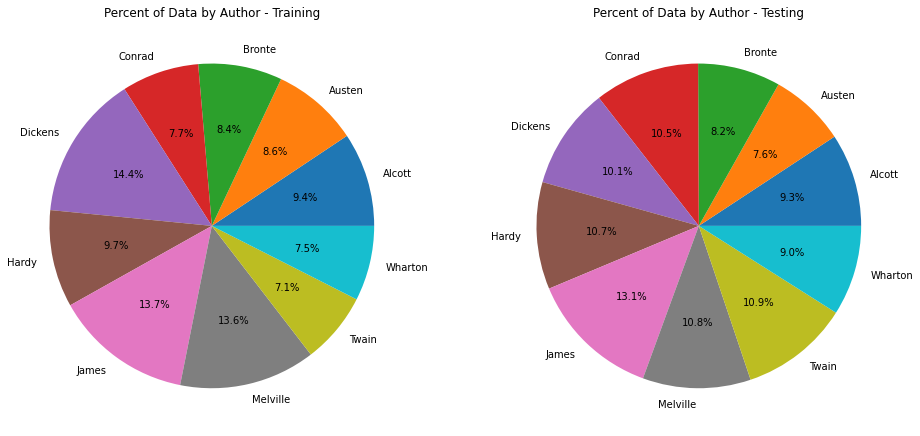

In [21]:
author_pie(df_train, df_test)

Included below are some box-and-whisker plots and histograms to illustrate which features are the most useful. For example, in 'SC_Count', which tracks the number of semicolons, notice that the frequency of semicolons varies from author to author. This is very likely an important feature to use when distinguishing between authors.

The ten histograms below further emphasize the usefulness of 'SC_Count'. The numbers on the y-axis can be ignored, since that's a result of the number of samples, which isn't uniform. Notice that many of the distributions are Gaussian-esque, but not all demonstrate this behavior. For instance, Alcott most frequently uses few to no semicolons. Even among the Gaussian-esque plots, their modes and the presence of tails distinguish them.

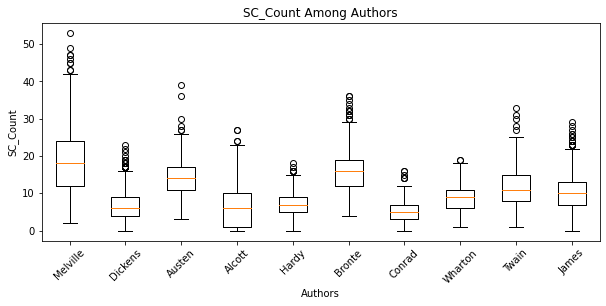

In [22]:
literary_box(df_train, 'SC_Count')

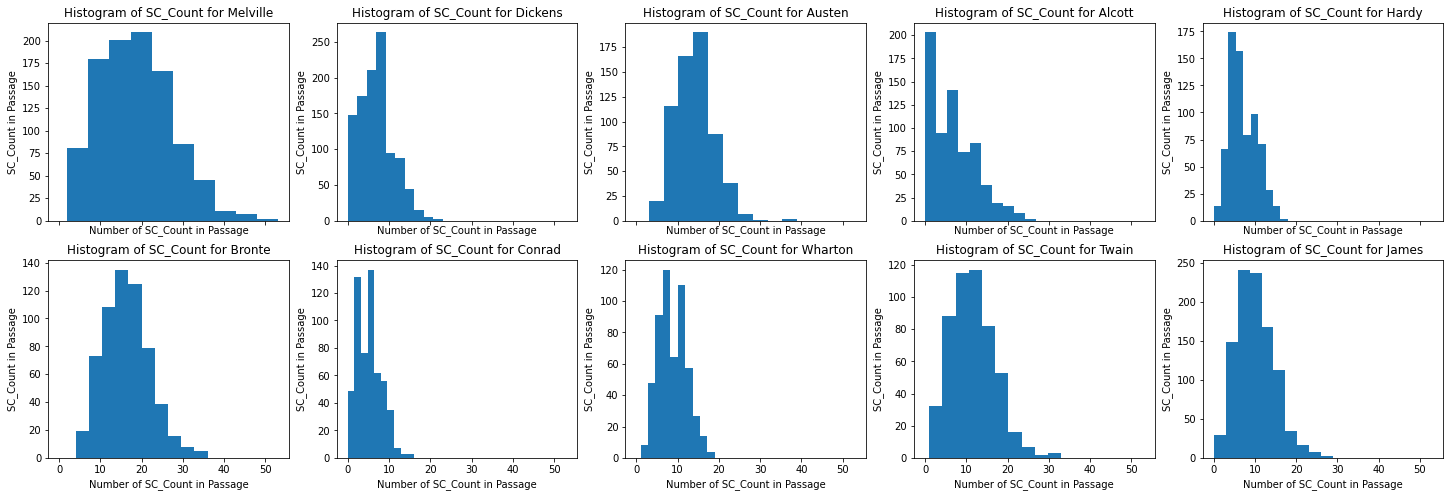

In [23]:
author_hist(df_train, 'SC_Count', 10)

Almost all of the features included are useful, and there are enough features that looking at them individually here would quickly become dull. Next, 'Co_Count' and 'RB' are included to show that the differences observed in 'SC_Count' happen in other variables as well, even if less pronounced.

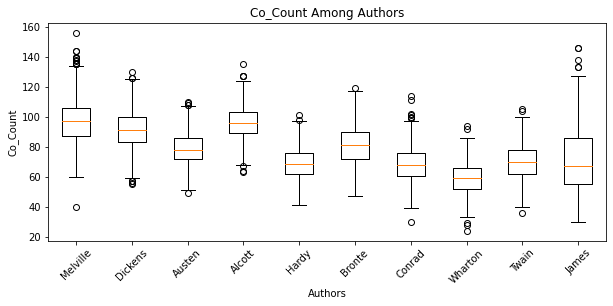

In [24]:
literary_box(df_train, 'Co_Count')

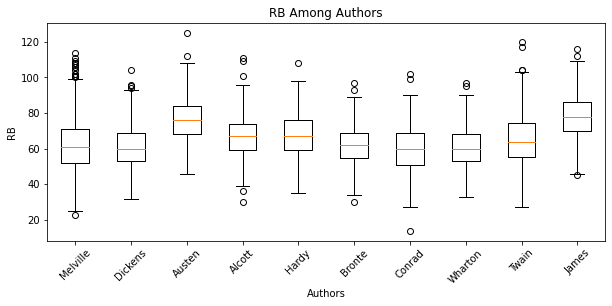

In [25]:
literary_box(df_train, 'RB')

The following two histograms are the most frequent distributions over the data. In the next section, features are selected for training the model. Most of the features selected have the Gaussian-esque distribution seen in the 'JJ' feature.

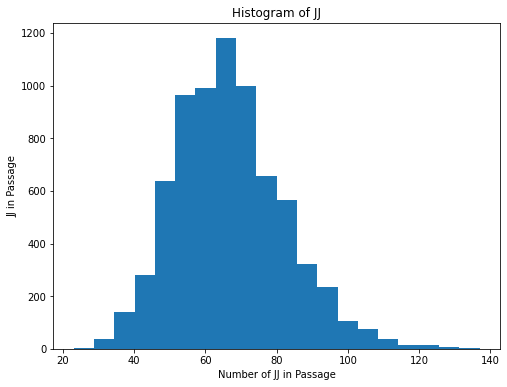

In [26]:
book_hist(df_train, 'JJ', 20)

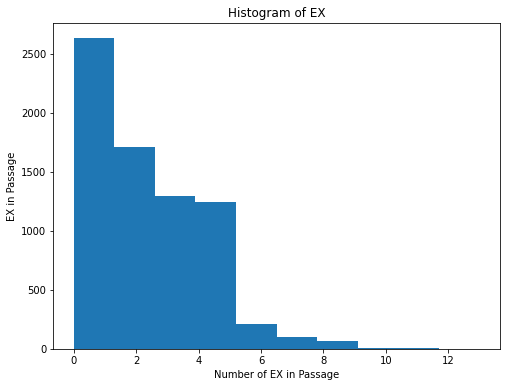

In [27]:
book_hist(df_train, 'EX', 10)

# Feature Selection

There are three main points that cause more investigation into a feature:

1. If most of the passages include no examples of the feature.
2. If the box-and-whisker plots for each author appear nearly identical for the feature.
3. If the standard deviation for a particular author is abnormally large for the feature.

These features have been investigated more informally and cross valdidation on the training set was used to determine if their removal was beneficial. The features included here were shown to either hurt the training of the model when included or make no noticeable difference.

In [28]:
#Determine which features do not appear in over 75% of the passages
for fea in df_train.columns:
    is_there = (df_train[df_train[fea] == 0].shape[0] / df_train.shape[0]) * 100
    if is_there >= 75:
        print(fea)

FW
LS
NNPS
WP$


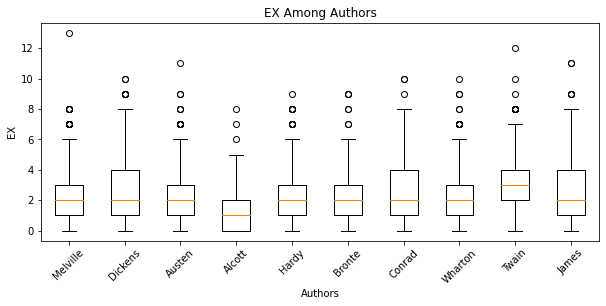

In [29]:
literary_box(df_train, 'EX')

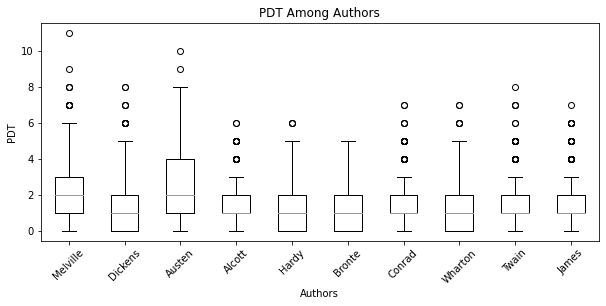

In [30]:
literary_box(df_train, 'PDT')

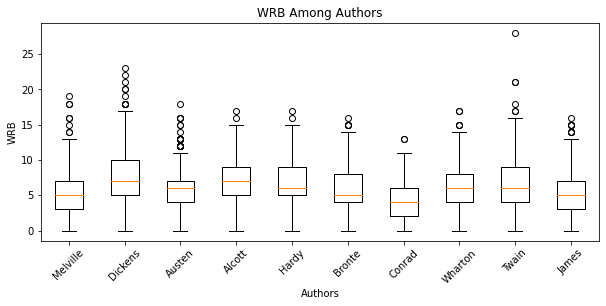

In [31]:
literary_box(df_train, 'WRB')

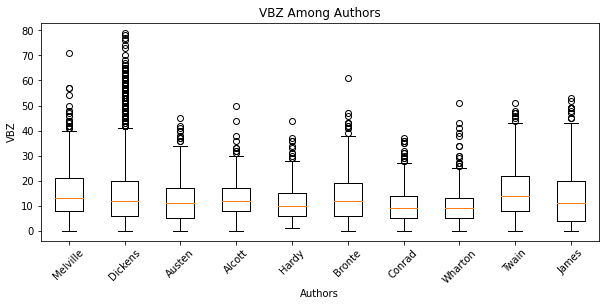

In [32]:
literary_box(df_train, 'VBZ')

This is the trickiest feature to handle since the box-and-whisker plots do appear different. Removing it from the training data did improve the accuracy. My best theory is that the high standard deviation on the Dickens data was creating noise and causing misclassification.

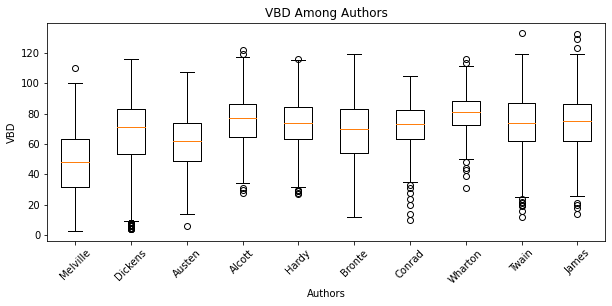

In [33]:
literary_box(df_train, 'VBD')

In [34]:
stat_table(df_train, 'VBD')

,Mean,SD,Median,Min,Max,0_Per
Melville,48.0396,19.9852,48,3,110,0
Dickens,64.7151,26.1306,71,4,116,0
Austen,60.8262,17.2693,62,6,107,0
Alcott,75.3059,15.9072,77,28,122,0
Hardy,73.2756,15.1422,74,27,116,0
Bronte,68.4283,19.6709,70,12,119,0
Conrad,71.6071,14.831,73,10,105,0
Wharton,80.1694,12.4159,81,31,116,0
Twain,73.4388,19.2616,74,12,133,0
James,73.8617,17.5604,75,14,132,0


# Model Selection

In [35]:
#Create independent and dependent variables for the train set
y = df_train.Author
X = df_train.drop(columns = ['Author', 'Title', 'LS', 'FW', 'NNPS', 'WP$', 'EX', 'WRB', 'PDT', 'VBD', 'VBZ'])

#Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y, shuffle = True, random_state = 37, test_size = .2)

#Create a scaler for the features
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)

Next, five models are trained on the training data. There is a logistic regression model, a quadratic discriminant analysis model, a support vector machine model, a neural network model, and a gradient boosted forest model. The neural network model and gradient boosted forest model were selected for their low bias, while the QDA model was selected since many of the features appear to have normal-ish distributions. SVM is an extremely nice 'out-of-the-box' classifier, which proved true here as well, and logistic regression performed relatively well too, so it was included. Since these will be used in a stacked model, the idea was to include models with varying degress of bias vs. variance to hopefully find a sweet spot in the trade-off.

These five models are combined into a final stacked model, which outperforms the original five models.

The hyperparameters for the models were selected using GridSearchCV.

In [36]:
#List of models
model_log = LogisticRegression(C=50, max_iter=5000, multi_class='multinomial', solver='newton-cg')
model_qda = QuadraticDiscriminantAnalysis()
model_svm = SVC(C=10, max_iter=100000)
model_nnt = MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=[100, 100], learning_rate_init=0.0001, max_iter=5000, random_state = 37)
model_gbf = GradientBoostingClassifier(ccp_alpha=0, learning_rate=0.3, max_depth=5, max_features=9, n_estimators=250, random_state = 37)

#Create a list of models to run through
model_choice = [model_log, model_qda, model_svm, model_nnt, model_gbf]

In [37]:
#Approximate model accuracy using 5-fold cross-validation
model_boxes = []
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

for model in model_choice:
    scores = []

    X_train2 = np.array(X_train_scale)
    y_train2 = np.array(y_train)

    #Split the data into the 5 folds
    for train_index, test_index in skf.split(X_train2,y_train2):
        X_split_train, X_split_test = X_train2[train_index], X_train2[test_index]
        y_split_train, y_split_test = y_train2[train_index], y_train2[test_index]
    
        #Fit split training data
        model.fit(X_split_train, y_split_train)
        scores.append(model.score(X_split_test, y_split_test)*100)   
        
    model_boxes.append(scores)

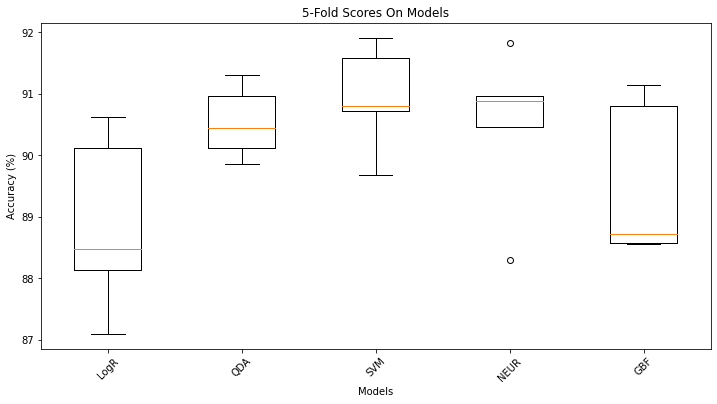

In [38]:
#Create a figure and axis object
fig, ax = plt.subplots(figsize = (12,6))
    
#Create the basic plot
ax.boxplot(model_boxes, labels = ['LogR', 'QDA', 'SVM', 'NEUR', 'GBF']);
    
#Label the plot
ax.set_title('5-Fold Scores On Models')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
    
#Rotate the x labels
plt.xticks(rotation = 45);

The graph above shows the cross-validation scores on the five models. Overall, all of the models perform relatively well.

Next, the five models are combined. These are used in the stacking classifier, which looks at the performance of each of the models and uses logisitc regression to make predictions. Since the selection of models is relatively diverse, and no model appears to significantly outperform the others, this should improve on these five models.

In [39]:
#Create stack model
stack_model = StackingClassifier(estimators = [('svm', model_svm), ('qda', model_qda), ('gbf', model_gbf), \
                                              ('nnt', model_nnt), ('log', model_log)], \
                          final_estimator = LogisticRegression(solver = 'lbfgs', C = 1, max_iter = 5000))

In [40]:
scores = []

X_train2 = np.array(X_train_scale)
y_train2 = np.array(y_train)

for train_index, test_index in skf.split(X_train2,y_train2):
    X_split_train, X_split_test = X_train2[train_index], X_train2[test_index]
    y_split_train, y_split_test = y_train2[train_index], y_train2[test_index]
    
    stack_model.fit(X_split_train, y_split_train)
    scores.append(stack_model.score(X_split_test, y_split_test)*100)   
        
model_boxes.append(scores)

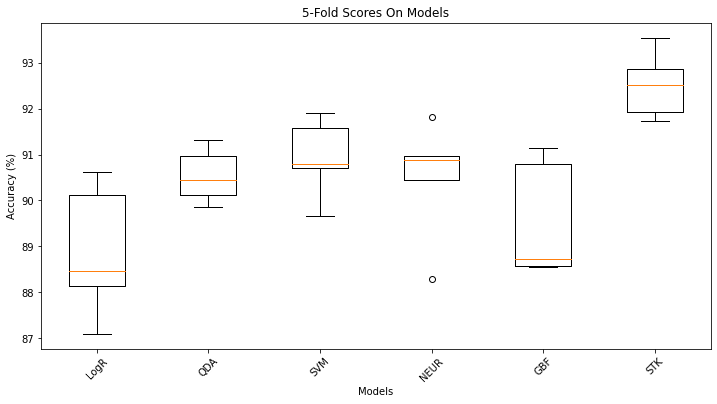

In [41]:
#Create a figure and axis object
fig, ax = plt.subplots(figsize = (12,6))
    
#Create the basic plot
ax.boxplot(model_boxes, labels = ['LogR', 'QDA', 'SVM', 'NEUR', 'GBF', 'STK']);
    
#Label the plot
ax.set_title('5-Fold Scores On Models')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
    
#Rotate the x labels
plt.xticks(rotation = 45);

Since the stacked model is a noticeable improvement over the original five models, only it is used during the validation and testing steps that follow.

# Validation Set and New Books Test Set

In [42]:
#Shuffle the Dataframes
df_test = df_test.sample(frac=1).reset_index(drop=True)

#Get test data
y_test = df_test.Author
X_test = df_test.drop(columns = ['Author', 'Title', 'LS', 'FW', 'NNPS', 'WP$', 'EX', 'WRB', 'PDT', 'VBD', 'VBZ'])

#Scale test data
X_test_scale = scaler.transform(X_test)

In [43]:
#Record the score on the validation set
stack_model.fit(X_train_scale, y_train)
val_score = stack_model.score(X_val_scale, y_val)*100

#Record the score on the new book test set
test_score = stack_model.score(X_test_scale, y_test)*100

In [44]:
print('Score on the validation set: {}%'.format(val_score))
print('Score on the test set: {}%'.format(test_score))

Score on the validation set: 93.74140302613479%
Score on the test set: 88.86810102899906%


In [45]:
print(confusion_matrix(y_test, stack_model.predict(X_test_scale), labels = ['Alcott', 'Austen', 'Bronte', 'Conrad', 'Dickens', \
                                                                'Hardy', 'James', 'Melville', 'Twain', 'Wharton']))
print(classification_report(y_test, stack_model.predict(X_test_scale)))

[[ 97   0   0   0   0   1   0   0   1   0]
 [  0  70   0   0   5   0   0   6   0   0]
 [  0   0  77   0   1   0   2   8   0   0]
 [  0   0   0 105   3   3   1   0   0   0]
 [  4   2   0   3  88   5   0   5   0   1]
 [  1   0   0   3   3  99   0   1   1   6]
 [  0   0   0   1   0   2 133   0   0   4]
 [  9   0   3   0   8   0   0  93   2   0]
 [  0   1   6   1   0   0   1   1 106   0]
 [  0   0   0   2   0   4   8   0   0  82]]
              precision    recall  f1-score   support

      Alcott       0.87      0.98      0.92        99
      Austen       0.96      0.86      0.91        81
      Bronte       0.90      0.88      0.89        88
      Conrad       0.91      0.94      0.93       112
     Dickens       0.81      0.81      0.81       108
       Hardy       0.87      0.87      0.87       114
       James       0.92      0.95      0.93       140
    Melville       0.82      0.81      0.81       115
       Twain       0.96      0.91      0.94       116
     Wharton       0.88     

Only a difference of $5\%$ is not bad for the validation score versus the testing score, given that the test set only includes books never seen by the model. As seen in the next section, it can sometimes be very difficult to predict a new book. As seen in the classification report, the model performs decently with most authors, with the most difficulty occuring when classifying Melville.

# Interlude: Difference Between Books - An Example

While a score of $88.87\%$ isn't bad on books the model has never seen before, this could vary based on the books given. As mentioned at the beginning of this project, the Dickens novels selected for the training and test set were written around the same time period. 'Oliver Twist' was written much earlier, and the model struggles to correctly identify it. This is demonstrated below.

In [47]:
#Load Oliver Twist data set
df_ot = pd.read_csv('Test_Data/1200_OT_Set.csv')
df_ot['Author'] = df_ot.Author.apply(lambda x: x.split(' ')[1])

#
y_ot = df_ot.Author
X_ot = df_ot.drop(columns = ['Author', 'Title', 'LS', 'FW', 'NNPS', 'WP$', 'EX', 'WRB', 'PDT', 'VBD', 'VBZ'])

#Scale Data
#scaler = MinMaxScaler()
#X_scale = scaler.fit_transform(X)
X_ot_scale = scaler.transform(X_ot)

#Fit and test model
#stack_model.fit(X_scale, y)
print(stack_model.score(X_ot_scale, y_ot))

0.2727272727272727


In [48]:
confusion_matrix(y_ot, model.predict(X_ot_scale), labels = ['Alcott', 'Austen', 'Bronte', 'Conrad', 'Dickens', \
                                                                'Hardy', 'James', 'Melville', 'Twain', 'Wharton'])

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  5,  4,  1, 56,  6,  1, 80,  4,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

According to the confusion matrix, the main obstacle to correctly classifying Dickens' 'Oliver Twist' is the presence of Melville. Many of the passages are misclassified as Melville, leading to the terrible accuracy score. It's possible that including more texts by Dickens that were written close to Oliver Twist would correct this error.

Although this could happen for other books as well, it appears extremely rare. So far, 'Oliver Twist' is the only book I've encountered that the model does a significantly worse job classifying. Investigating what is happening and how to correct it would be an interesting follow-up question to this project.

# Effect of Increasing Passage Length

There is one final method for increasing the accuracy of the model: increasing the length of the passage. Below we graph the change in accuracy as the passage length changes.

In [51]:
#Loads data given a passage length, cleans it, then outputs train sets, validation sets, full train sets, and test sets
def load_clean_data(numb):
    #Load DataFrame of specified token passages
    df_train = pd.read_csv('Training_Data/'+str(numb)+'_Train_Set.csv')
    df_test = pd.read_csv('Test_Data/'+str(numb)+'_Test_Set.csv')

    #Get rid of Louisa May Alcott's middle name
    df_train.Author.replace({'Louisa May Alcott': 'Louisa Alcott'}, inplace = True)
    df_test.Author.replace({'Louisa May Alcott': 'Louisa Alcott'}, inplace = True)

    #Only use last names (since we only have one Bronte)
    df_train['Author'] = df_train.Author.apply(lambda x: x.split(' ')[1])
    df_test['Author'] = df_test.Author.apply(lambda x: x.split(' ')[1])
    
    #Create independent and dependent variables for the train set
    y = df_train.Author
    X = df_train.drop(columns = ['Author', 'Title', 'LS', 'FW', 'NNPS', 'WP$', 'EX', 'WRB', 'PDT', 'VBD', 'VBZ'])

    #Split into training and validation set
    X_train, X_val, y_train, y_val = train_test_split(X,y, shuffle = True, random_state = 37, test_size = .2)

    #Create a scaler for the features
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)
    
    #Shuffle the Dataframes
    df_test = df_test.sample(frac=1).reset_index(drop=True)

    #Get test data
    y_test = df_test.Author
    X_test = df_test.drop(columns = ['Author', 'Title', 'LS', 'FW', 'NNPS', 'WP$', 'EX', 'WRB', 'PDT', 'VBD', 'VBZ'])

    #Scale test data
    X_test_scale = scaler.transform(X_test)
        
    return (X_train_scale, y_train, X_val_scale, y_val, X_test_scale, y_test)

In [52]:
#Code fitting, validating and testing for each of the different sizes using the stacked model
lengths = [600, 800, 1200, 1500, 1800, 2000, 3000, 4000, 8000, 10000]

#Create empty lists to fill with scores
pass_val_score = []
pass_test_score = []

#Loop through the passage lengths, testing the stack model
for numb in lengths:
    
    #Get data split into training, validation, and testing sets
    X_train_scale, y_train, X_val_scale, y_val, X_test_scale, y_test = load_clean_data(numb)
    
    #Validation score
    stack_model.fit(X_train_scale, y_train)
    pass_val_score.append(stack_model.score(X_val_scale, y_val))
    
    #Test score
    pass_test_score.append(stack_model.score(X_test_scale, y_test))


/home/mpullins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mpullins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mpullins/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mpullins/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mpullins/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mpullins/.

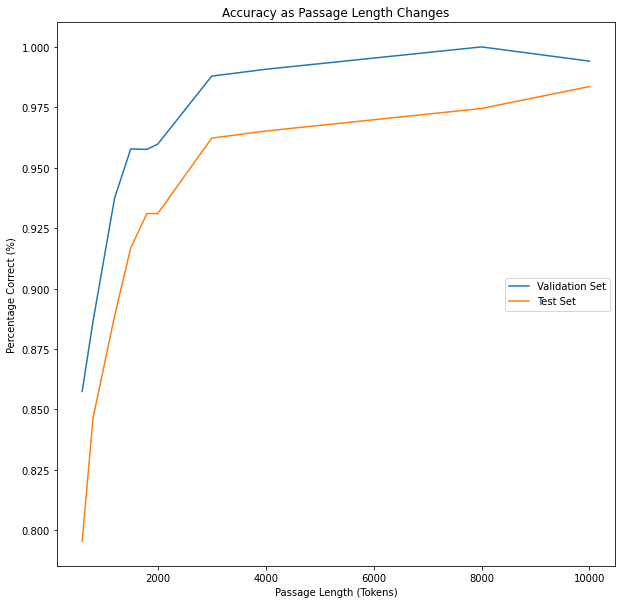

In [53]:
fig, ax = plt.subplots(figsize = (10,10))

ax.plot(lengths, pass_val_score)
ax.plot(lengths, pass_test_score)

#Label the plot
ax.set_title('Accuracy as Passage Length Changes')
ax.set_xlabel('Passage Length (Tokens)')
ax.set_ylabel('Percentage Correct (%)')

ax.legend(labels = ['Validation Set', 'Test Set'], loc = 7);

Unsurprisingly, the validation set continues to outperform the test set. For the test set, the increase in passage length increases the accuracy of the classifier. However, the validation set starts suffering after $8000$. This makes sense. As the passage size becomes larger, there are fewer data points, so it becomes harder to train the model. If this graph continued, it's likely that the test score would start decreasing as well.

# Conclusions

The goal of this project was relatively narrow: can authors be predicted based on statistics from an excerpt of text? To this, the answer seems to be yes, but it does depend on the length of the text, and some books could be harder to predict than others (e.g. 'Oliver Twist'). The scope is not increased to what features are relevant because of correlation between variables. There are instances of correlation and collinearity between features, so interpretations of a model, such as looking at coefficients for a logarithmic regression, may not fully describe the effects of each variable. Eliminating the collinearity and multicollinearity results in far too few variables to make accurate predictions anymore. 

Within the scope of merely predicting the author, it appears that increasing the passage length has a dramatic effect on the accuracy. Balancing accuracy with maximizing data points, $3000$ tokens is optimal for the test set. There are a few possible explanations for this effect. One possible reason is that with smaller token sizes, there will be more 'outlier' passages that do not resemble the author's statistics. As larger passage lengths are used, these 'outlier' passages become more uniform, giving better predictions for the author. Another explanation is that the differences between authors become more pronounced as larger passages are used. For instance, if one author uses semicolons frequently and another does not, then with larger passages, there is a smaller chance for the range of 'Count_SC' to overlap, allowing easier predictions.

More data could also be added in the form of more books by an author, but this is very limited. All of Jane Austen's books and Charlotte Bronte's books have been used, so there are no more available data points for them. This stands opposite Dickens, where there are many books that could be added. It would be interesting to add more books to the dataset, skewing the data, and seeing how this affected the predictions made by the model. Another change that could be made is including more authors. This project began with only Austen and Dickens, and more authors were added over time. With each author, there might be a decrease in accuracy. This is best illustrated with the section on 'Oliver Twist'. If Melville was not included, then there really wouldn't have been an 'Oliver Twist'-problem. So, choice of authors makes a difference here.

It's important to address some potential problems and limitations of this analysis. For one, all of the book data is created from transcribed texts and there could be features skewed by transcription. I have tried to minimize these, but it's not easy to spot all of them. For example, some texts use underscores to indicate italics and others do not. For these reason, italics were excluded from the features, despite probably being useful. The use of em-dashes was included, but there is some evidence that this may not be universal either. Quotations marks were changed to be uniform, but that was once a problem as well. I believe most transcriptions differences have been addressed, but there could be some still lurking. Another limitation, which is related, is that all data is seen through the lens of my data extraction program. Any book must be fed through my data extraction program, and this might introduce errors or data leakage. If this is occurring, I believe it's relatively minor since I have combed through the raw data for suspicious numbers and those only occur on the 'D_Count' statistic for a two or three books from different authors. And this might not even be a problem, since em-dashes are not the most common punctuation anyway.

Before concluding this project, there are future questions that can be addressed. Probably the most interesting question is whether an author's books are more similar if they were written closer together. This could be pursued in conjunction with figuring out how to correctly identify 'Oliver Twist', if it turns out that this theory is true. Another direction could be figuring out how to remove variables to make accurate, interpretable models. This seems fairly difficult for this problem, however. Finally, it could be interesting to create models predicting the titles of novels within a single author, then comparing these results across authors. In informal testing, it appears that some authors novels are quite difficult to tell apart (Austen), while others are very easy (Dickens). Understanding why would be fun.

# Epilogue

The approach above is not the best way to handle text data. To demonstrate this, we end this project with a quick look at using a bag-of-words approach to achieve a better accuracy score.

In [54]:
#Import new function needed for bag-of-words
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
#Load data
df_train = pd.read_csv('1200_Train_Bag.csv')
df_test = pd.read_csv('1200_Test_Bag.csv')

#Get rid of Louisa May Alcott's middle name
df_train.Author.replace({'Louisa May Alcott': 'Louisa Alcott'}, inplace = True)
df_test.Author.replace({'Louisa May Alcott': 'Louisa Alcott'}, inplace = True)

#Only use last names (since we only have one Bronte)
df_train['Author'] = df_train.Author.apply(lambda x: x.split(' ')[1])
df_test['Author'] = df_test.Author.apply(lambda x: x.split(' ')[1])

#Only select the text itself
X_train_full = df_train.Excerpt
y_train_full = df_train.Author
X_test = df_test.Excerpt
y_test = df_test.Author

#Create training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, shuffle = True, random_state = 37, test_size = .2)

#Convert text to bag of words
vect = CountVectorizer().fit(X_train)
X_train_vector = vect.transform(X_train)
X_val_vector = vect.transform(X_val)
X_test_vector = vect.transform(X_test)

In [56]:
#Create model
bag_model = SVC(kernel = 'rbf', C = 10).fit(X_train_vector, y_train)

#Get scores for test set and validation set
val_score = bag_model.score(X_val_vector, y_val)
test_score = bag_model.score(X_test_vector, y_test)

print('Score on the validation set: {}%'.format(val_score))
print('Score on the test set: {}%'.format(test_score))

Score on the validation set: 0.9944979367262724%
Score on the test set: 0.9391955098222639%


In [57]:
print(confusion_matrix(y_test, bag_model.predict(X_test_vector), labels = ['Alcott', 'Austen', 'Bronte', 'Conrad', 'Dickens', \
                                                                'Hardy', 'James', 'Melville', 'Twain', 'Wharton']))
print(classification_report(y_test, bag_model.predict(X_test_vector)))

[[ 99   0   0   0   0   0   0   0   0   0]
 [  0  79   0   0   1   1   0   0   0   0]
 [  0   0  86   1   0   0   0   1   0   0]
 [  0   1   7 101   2   0   0   1   0   0]
 [  1   0   2   2  92   7   0   2   0   2]
 [  0   0   0   0   0 114   0   0   0   0]
 [  0   0   0   0   0   0 140   0   0   0]
 [  4   0   1   0  22   0   0  87   1   0]
 [  0   0   1   0   1   0   0   1 113   0]
 [  0   0   0   0   0   0   3   0   0  93]]
              precision    recall  f1-score   support

      Alcott       0.95      1.00      0.98        99
      Austen       0.99      0.98      0.98        81
      Bronte       0.89      0.98      0.93        88
      Conrad       0.97      0.90      0.94       112
     Dickens       0.78      0.85      0.81       108
       Hardy       0.93      1.00      0.97       114
       James       0.98      1.00      0.99       140
    Melville       0.95      0.76      0.84       115
       Twain       0.99      0.97      0.98       116
     Wharton       0.98     

With very little effort, the accuracy on the test set jumped up $5\%$ by using the bag-of-words approach with word vectors. It's not surprising that the more standard approach to this problem yielded better results. Of course, the intent of this project was to see how accurate the model could be without bag-of-words, so a $5\%$ difference is still not terrible.

There is one interesting thing to note: the bag-of-words approach is significantly worse at telling Melville and Dickens apart. While using word vectors is overall superior, if tasked with differentiating between Melville and Dickens, our original approach appears much better. 